# Disentangled Multimodal Representation Learning for Recommendation (DMRL)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import cornac
import numpy as np
import pandas as pd
from cornac.metrics import NDCG
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality
from cornac.models.dmrl.recom_dmrl import DMRL

from utils import load_data, preprocessing_content_data


# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/home/matheus/miniconda/envs/sistema_recomendacao_tp2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and process data

In [3]:
ratings, content, targets = load_data()

In [4]:
ratings["TimestampDate"] = ratings['Timestamp'].dt.date
ratings.loc[ratings.Rating == 0, "Rating"] = 0.01

In [5]:
content_columns = content.columns.to_list()
content_columns.pop(0)

'ItemId'

In [12]:
content["Poster"][0]

'https://m.media-amazon.com/images/M/MV5BNGQ5MjZjYzgtYjJhMC00NDIzLTk0NjgtNmRjZDc1ZGM5MmM5XkEyXkFqcGdeQXVyOTUzMjk0NDE@._V1_SX300.jpg'

In [10]:
content

,ItemId,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,Type,DVD,BoxOffice,Production,Website,Response,totalSeasons,Season,Episode,seriesID
0,c9f0f895fb,Edison Kinetoscopic Record of a Sneeze,1894,N/A,09 Jan 1894,1 min,"Documentary, Short",William K.L. Dickson,N/A,Fred Ott,A man (Edison's assistant) takes a pinch of sn...,None,United States,1 win,https://m.media-amazon.com/images/M/MV5BNGQ5Mj...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,5.5,"1,980",movie,N/A,N/A,N/A,N/A,True,NaN,NaN,NaN,NaN
1,d3d9446802,Leaving the Factory,1895,Not Rated,22 Mar 1895,1 min,"Documentary, Short",Louis Lumière,N/A,N/A,A man opens the big gates to the Lumière facto...,None,France,N/A,https://m.media-amazon.com/images/M/MV5BY2EwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,6.9,"6,633",movie,N/A,N/A,N/A,N/A,True,NaN,NaN,NaN,NaN
2,c20ad4d76f,The Arrival of a Train,1896,Not Rated,25 Jan 1896,1 min,"Documentary, Short","Auguste Lumière, Louis Lumière",N/A,"Madeleine Koehler, Marcel Koehler, Mrs. August...",A group of people are standing in a straight l...,None,France,N/A,https://m.media-amazon.com/images/M/MV5BZjE2MG...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,7.5,"11,407",movie,N/A,N/A,N/A,N/A,True,NaN,NaN,NaN,NaN
3,8e296a067a,The Oxford and Cambridge University Boat Race,1895,N/A,N/A,N/A,"Short, News, Sport",Birt Acres,N/A,N/A,Although the content of this film is primitive...,None,United Kingdom,N/A,https://m.media-amazon.com/images/M/MV5BOGFiZj...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,4.2,39,movie,N/A,N/A,N/A,N/A,True,NaN,NaN,NaN,NaN
4,54229abfcf,The House of the Devil,1896,Not Rated,24 Dec 1896,3 min,"Short, Horror",Georges Méliès,Georges Méliès,"Jehanne d'Alcy, Jules-Eugène Legris, Georges M...",A bat flies into an ancient castle and transfo...,None,France,N/A,https://m.media-amazon.com/images/M/MV5BY2RkZD...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,6.7,"3,268",movie,N/A,N/A,N/A,N/A,True,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38007,6c0ffc79d0,Yara,2021,TV-14,05 Nov 2021,96 min,"Crime, Drama, Thriller",Marco Tullio Giordana,"Graziano Diana, Giacomo Martelli","Isabella Ragonese, Alessio Boni, Thomas Trabacchi",A determined prosecutor becomes consumed with ...,Italian,Italy,N/A,https://m.media-amazon.com/images/M/MV5BMWFhYz...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,6.2,"3,202",movie,05 Nov 2021,N/A,N/A,N/A,True,NaN,NaN,NaN,NaN
38008,e02f371f8c,Lords of Scam,2021,N/A,03 Nov 2021,105 min,"Documentary, Crime",Guillaume Nicloux,Olivier Bouchara,N/A,This documentary traces the rise and crash of ...,French,France,N/A,https://m.media-amazon.com/images/M/MV5BNWYwND...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,6.3,418,movie,03 Nov 2021,N/A,N/A,N/A,True,NaN,NaN,NaN,NaN
38009,8c2a2a22b8,Cash,2021,N/A,19 Nov 2021,118 min,"Comedy, Drama",Rishab Seth,"Vishesh Bhatt, Rishab Seth, Aarsh Vora","Amol Parashar, Smiriti Kalra, Gulshan Grover",The government announces demonetization. The s...,Hindi,India,N/A,https://m.media-amazon.com/images/M/MV5BMGFmYz...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,7.2,"1,779",movie,N/A,N/A,N/A,N/A,True,NaN,NaN,NaN,NaN
38010,ae74ba6bb7,Sompoy,2021,N/A,04 Nov 2021,120 min,"Comedy, Romance","Anawat Phromchae, Aroonakorn Pick","Anawat Phromchae, Aroonakorn Pick","Pijakkana Wongsarattanasin, Tanapol Jarujittra...","A love triangle story of a young woman named ""...",Thai,Thailand,N/A,https://m.media-amazon.com/images/M/MV5BYmRiYm...,[],N/A,N/A,5,movie,N/A,N/A,N/A,N/A,True,NaN,NaN,NaN,NaN


In [6]:
content_processed = content[['ItemId']].copy()
content_processed["text"] = content[content_columns].astype(str).fillna('').agg(' '.join, axis=1)

In [8]:
content_processed

,ItemId,text
0,c9f0f895fb,Edison Kinetoscopic Record of a Sneeze 1894 N/...
1,d3d9446802,Leaving the Factory 1895 Not Rated 22 Mar 1895...
2,c20ad4d76f,The Arrival of a Train 1896 Not Rated 25 Jan 1...
3,8e296a067a,The Oxford and Cambridge University Boat Race ...
4,54229abfcf,The House of the Devil 1896 Not Rated 24 Dec 1...
...,...,...
38007,6c0ffc79d0,"Yara 2021 TV-14 05 Nov 2021 96 min Crime, Dram..."
38008,e02f371f8c,Lords of Scam 2021 N/A 03 Nov 2021 105 min Doc...
38009,8c2a2a22b8,"Cash 2021 N/A 19 Nov 2021 118 min Comedy, Dram..."
38010,ae74ba6bb7,"Sompoy 2021 N/A 04 Nov 2021 120 min Comedy, Ro..."


## Basic analysis

In [7]:
ratings.head()

,UserId,ItemId,Timestamp,Rating,TimestampDate
0,c4ca4238a0,91766eac45,2013-10-05 22:00:50,8.0,2013-10-05
1,c81e728d9d,5c739554f7,2013-08-17 16:26:38,9.0,2013-08-17
2,c81e728d9d,48f6d7ce7c,2013-08-17 13:28:27,8.0,2013-08-17
3,c81e728d9d,e9318d627a,2013-06-15 15:38:09,1.0,2013-06-15
4,a87ff679a2,17e6357973,2014-01-31 23:27:59,8.0,2014-01-31


In [ ]:
# Number of unique users and items
ratings.UserId.nunique(), ratings.ItemId.nunique()

In [ ]:
# how many itens purchased by each user purchase
ratings.groupby(["UserId", 'Timestamp'])["ItemId"].nunique().value_counts()

In [ ]:
# how many itens purchased by each user day by day
ratings.groupby(["UserId", 'TimestampDate'])["ItemId"].nunique().value_counts()

In [ ]:
# how many times each user purchased items
ratings.groupby("UserId")['Timestamp'].nunique().value_counts()

In [ ]:
# how many times each user purchased items per day
ratings.groupby("UserId")['TimestampDate'].nunique().value_counts()

In [ ]:
content.isna().sum()

In [ ]:
ratings.Rating.unique()

## Train model

In [10]:
item_text_modality = TextModality(
    corpus=content_processed.text.to_list(),
    ids=content_processed.ItemId.to_list(),
)

In [11]:
ratio_split = RatioSplit(
    data=ratings[['UserId', 'ItemId', 'Rating']].values.tolist(),
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=123,
    rating_threshold=0.5,
    item_text=item_text_modality,
)

rating_threshold = 0.5
exclude_unknowns = True
---
Training data:
Number of users = 46776
Number of items = 26964
Number of ratings = 527776
Max rating = 10.0
Min rating = 0.0
Global mean = 7.3
---
Test data:
Number of users = 46776
Number of items = 26964
Number of ratings = 123946
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 46776
Total items = 26964


In [ ]:
# uid_map = ratio_split.train_set.uid_map
# iid_map = ratio_split.train_set.iid_map

In [12]:
# Instantiate DMRL recommender
dmrl_recommender = DMRL(
    batch_size=4096,
    epochs=20,
    log_metrics=False,
    learning_rate=0.01,
    num_factors=2,
    decay_r=0.5,
    decay_c=0.01,
    num_neg=3,
    embedding_dim=100,
)

In [13]:
# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=ratio_split, models=[dmrl_recommender], metrics=[NDCG()]
).run()


[DMRL] Training started!


/home/matheus/miniconda/envs/sistema_recomendacao_tp2/lib/python3.9/site-packages/cornac/models/dmrl/transformer_text.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sa

Using device cuda for training
  batch 5 loss: 2839.7349609375
  batch 10 loss: 2838.8173828125
  batch 15 loss: 2823.062060546875
  batch 20 loss: 2752.82568359375
  batch 25 loss: 2639.58984375
  batch 30 loss: 2528.148681640625
  batch 35 loss: 2455.21103515625
  batch 40 loss: 2305.06240234375
  batch 45 loss: 2113.9444580078125
  batch 50 loss: 1926.7844482421874
  batch 55 loss: 1752.9337890625
  batch 60 loss: 1700.745751953125
  batch 65 loss: 1653.53310546875
  batch 70 loss: 1632.4863525390624
  batch 75 loss: 1605.7842529296875
  batch 80 loss: 1592.30791015625
  batch 85 loss: 1568.596435546875
  batch 90 loss: 1565.9516357421876
  batch 95 loss: 1551.0882080078125
  batch 100 loss: 1533.9483154296875
  batch 105 loss: 1506.35341796875
  batch 110 loss: 1498.362939453125
  batch 115 loss: 1481.4756591796875
  batch 120 loss: 1442.396435546875
  batch 125 loss: 1490.872265625
Epoch: 0 is done
  batch 5 loss: 1323.680517578125
  batch 10 loss: 1297.060302734375
  batch 15 los

Ranking: 100%|██████████| 19966/19966 [05:46<00:00, 57.69it/s]


TEST:
...
     | NDCG@-1 | Train (s) | Test (s)
---- + ------- + --------- + --------
DMRL |  0.2341 |   64.3903 | 346.1104



In [73]:
# como usar esse algoritmo para tratar itens novos?
# # como usar esse algoritmo para tratar usuarios novos?


# eu tenho o conteudo de todos os itens, incluive itens que estao apenas n conjunto de teste?

In [77]:
target_prediction = targets.copy()
target_prediction["Rating"] = -1

user_id_list = targets.UserId.unique()
for user_id in user_id_list:
    # Get the train dataframe index of the user to predict
    user_index = ratio_split.train_set.uid_map.get(user_id)

    if user_index is None:
        print(f"User {user_id} is not in the train set")
        continue

    # Flter by items to predict 
    items_to_predict = targets.loc[targets.UserId == user_id, "ItemId"].to_list()

    # Get the train dataframe index of the items to predict
    items_to_predict_index = np.array([ratio_split.train_set.iid_map.get(item_id) for item_id in items_to_predict])

    items_to_predict_tensor = torch.tensor([idx for idx in items_to_predict_index if idx is not None])

    # Get the position of items that are not in the train set
    none_indices = [i for i, x in enumerate(items_to_predict_index) if x is None]

    # Get the prediction for the items
    line_rating = dmrl_recommender.score(user_index=user_index, item_indices=items_to_predict_tensor)

    # Insert -1 in the position of items that are not in the train set
    for index_to_insert in none_indices:
        line_rating = np.insert(line_rating, index_to_insert, -1)

    # Insert the prediction in the target_prediction dataframe
    target_prediction.loc[targets.UserId == user_id, "Rating"] = line_rating

User 019f8b946a is not in the train set
User 046dd69e7a is not in the train set
User 08b0ad8c2b is not in the train set
User 0b49b88c68 is not in the train set
User 0bf04bee73 is not in the train set
User 0d858ba37c is not in the train set
User 0e095e054e is not in the train set
User 1230a1696b is not in the train set
User 1344a31569 is not in the train set
User 14345de2c2 is not in the train set
User 19892cd2c9 is not in the train set
User 1c53aae1c1 is not in the train set
User 1e44fdf9c4 is not in the train set
User 23ea75a4cd is not in the train set
User 254a5ecb7a is not in the train set
User 263138a8b9 is not in the train set
User 289319b9e5 is not in the train set
User 290db70122 is not in the train set
User 2a38a4a931 is not in the train set
User 2b12a84466 is not in the train set
User 2b634a9d15 is not in the train set
User 2bba9f4124 is not in the train set
User 2e61866ea9 is not in the train set
User 2efbe23ad5 is not in the train set
User 3002c4f348 is not in the train set


In [79]:
target_prediction = target_prediction.sort_values(["UserId", "Rating"], ascending=[True, False])

In [80]:
target_prediction.to_csv("submissao_2_DMRL.csv", index=False)

In [81]:
target_prediction = target_prediction.drop(columns="Rating")

In [82]:
target_prediction.to_csv("submissao_2_DMRL_sem_rating.csv", index=False)

In [225]:
import json
import pandas as pd
import matplotlib as plt

# Step 1: Load the JSONL file containing movie data
with open('data/content.jsonl', 'r') as f:
    movies_data = [json.loads(line) for line in f]

# Step 2: Load the CSV file containing user ratings
df = pd.read_csv('submissoes/lightfm_versao_2_puro.csv')
# Normalize the Rating column
df["Rating"] = df["Rating"].apply(lambda x: min(x, 10))
print(df.head())

# Step 3: Create a dictionary of imdbRatings from the movies data
imdbRatings = {movie['ItemId']: movie['imdbRating'] for movie in movies_data}
metascore = {movie['ItemId']: movie['Metascore'] for movie in movies_data}
imdbVotes = {movie['ItemId']: movie['imdbVotes'] for movie in movies_data}
boxOffice = {}

for movie in movies_data:
    item_id = movie['ItemId']
    box_office = movie.get('BoxOffice', 'N/A')
    if box_office == 'N/A':
        box_office = 0  # Replace 'N/A' with 0
    else:
        # Remove any non-numeric characters like "$" and commas, then convert to an integer
        box_office = int(''.join(c for c in box_office if c.isdigit()))
    boxOffice[item_id] = box_office


       UserId      ItemId    Rating
0  0006246bee  80d1dae630  0.020822
1  0006246bee  899610035b -2.372907
2  0006246bee  aad36aac60 -2.551281
3  0006246bee  c1ee6829f5 -2.712074
4  0006246bee  ade4907055 -3.027950


<Axes: >

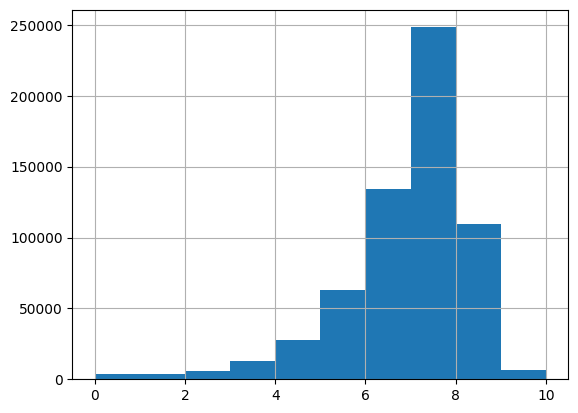

In [226]:
df["Rating"] = df["Rating"].apply(lambda x: max(x, -20))
df['Rating'] = (df['Rating'] - df['Rating'].min()) / (df['Rating'].max() - df['Rating'].min()) * 10
df['Rating'].hist()

<Axes: >

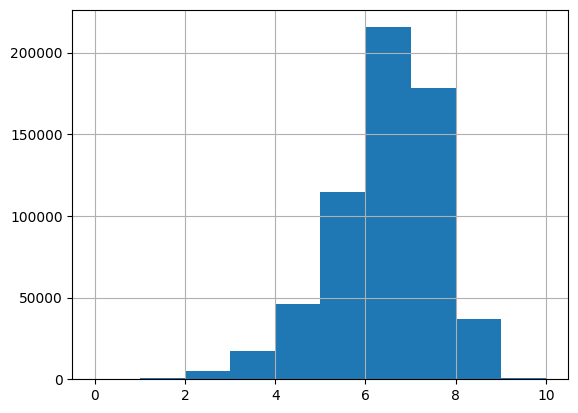

In [227]:
df['imdbRating'] = df['ItemId'].map(imdbRatings)
df["imdbRating"] = pd.to_numeric(df["imdbRating"], errors='coerce')
df["imdbRating"] = df["imdbRating"].fillna(df['Rating'])
df["imdbRating"].hist()

In [228]:
df['BoxOffice'] = df['ItemId'].map(boxOffice)
df["BoxOffice"] = df["BoxOffice"].replace({"$": "", ",": ""}, regex=True)
df["BoxOffice"] = pd.to_numeric(df["BoxOffice"], errors='coerce')
min_box_office = df['BoxOffice'].min()
max_box_office = df['BoxOffice'].max()
df['BoxOffice'] = (df['BoxOffice'] - min_box_office) / (max_box_office - min_box_office) * 10

In [229]:
df['Metascore'] = df['ItemId'].map(metascore)
df["Metascore"] = pd.to_numeric(df["Metascore"], errors='coerce')
df["Metascore"] = df["Metascore"]/10
df["Metascore"] = df["Metascore"].fillna(df['imdbRating'])

In [230]:
df['Score'] = (
    0.3 * df["imdbRating"] +
    0.2 * df["BoxOffice"] +
    0.3 * df["Metascore"] +
    0.3 * df["Rating"]
)
df['Score'] = df['Score'].fillna(df['Rating'])

<Axes: >

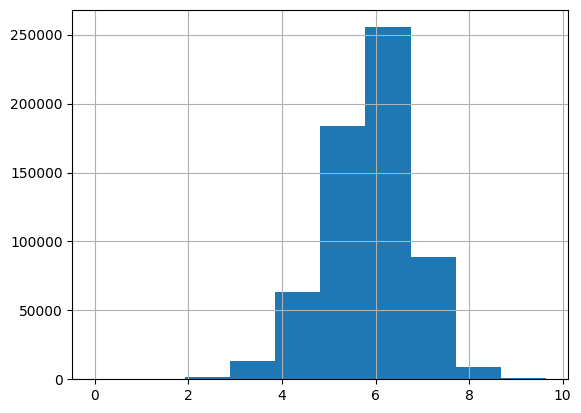

In [231]:
df['Score'].hist()

In [232]:
df = df.sort_values(['UserId', 'Score'], ascending=[True, False])

In [233]:
df

,UserId,ItemId,Rating,imdbRating,BoxOffice,Metascore,Score
13,0006246bee,1e5bdbcb76,7.149924,8.1,0.582000,8.8,7.331377
7,0006246bee,dcba99a1a6,7.448406,7.7,0.244096,9.0,7.293341
5,0006246bee,ea200e9d98,7.582276,8.2,0.000000,7.9,7.104683
91,0006246bee,b273133e05,6.400281,7.9,1.765452,8.2,7.103175
87,0006246bee,16ec9e966c,6.461445,7.9,0.000000,9.3,7.098434
...,...,...,...,...,...,...,...
616130,fffffe98d0,fca8263961,3.857360,3.3,0.000000,3.3,3.137208
616188,fffffe98d0,3930f55a95,3.189157,3.5,0.117200,3.3,3.020187
616135,fffffe98d0,e5076931c7,3.834112,4.2,0.002087,1.8,2.950651
616149,fffffe98d0,aec7adaa71,3.625858,2.6,0.000000,2.6,2.647757


In [234]:
df = df.drop(columns=['Rating', 'imdbRating', 'Score', 'BoxOffice', 'Metascore'])

In [235]:
df.to_csv('lightfm_pure_average_5.csv', index=False)

In [2]:
# Step 4: Add the imdbRating to each row in the CSV file
df['Metascore'] = df['ItemId'].map(metascore)
df['imdbRating'] = df['ItemId'].map(imdbRatings)
df['BoxOffice'] = df['ItemId'].map(boxOffice)
df['imdbVotes'] = df['ItemId'].map(imdbVotes)

df["Metascore"] = pd.to_numeric(df["Metascore"], errors='coerce')
df["imdbRating"] = pd.to_numeric(df["imdbRating"], errors='coerce')
df["imdbVotes"] = pd.to_numeric(df["imdbVotes"], errors='coerce')
df["BoxOffice"] = df["BoxOffice"].replace({"$": "", ",": ""}, regex=True)
df["BoxOffice"] = pd.to_numeric(df["BoxOffice"], errors='coerce')
min_box_office = df['BoxOffice'].min()
max_box_office = df['BoxOffice'].max()
df['BoxOffice'] = (df['BoxOffice'] - min_box_office) / (max_box_office - min_box_office) * 10
min_imdb_vote = df['imdbVotes'].min()
max_imdb_vote = df['imdbVotes'].max()
df['imdbVotes'] = (df['imdbVotes'] - min_imdb_vote) / (max_imdb_vote - min_imdb_vote) * 10

df["Metascore"] = df["Metascore"]/10
df["Metascore"] = df["Metascore"].fillna(5)
df["imdbRating"] = df["imdbRating"].fillna(5)
df["imdbVotes"] = df["imdbVotes"].fillna(0)
df['WeightedScore'] = (
    0.3 * df["imdbRating"] +
    0.3 * df["imdbVotes"] +
    0.2 * df["BoxOffice"] +
    0.1 * df["Metascore"] +
    0.1 * df["Rating"]
)

df_ordered = df.sort_values(['UserId', 'WeightedScore'], ascending=[True, False])
df_ordered.to_csv('submissao_2_with_imdb.csv', index=False)

In [3]:

df_ordered = df_ordered.drop(columns=["Rating", "Metascore", "imdbRating", "BoxOffice", "imdbVotes"])
df_ordered.to_csv('submissao_2_with_imdb.csv', index=False)